<a href="https://colab.research.google.com/github/RomaricKanyamibwa/Normalisation-de-concepts-medicaux/blob/master/CNN_projet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.layers import Dense, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Sequential
import matplotlib.pylab as plt
import logging


Using TensorFlow backend.


In [0]:
!pip3 install --upgrade gensim

In [0]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

In [0]:
from gensim.models import Word2Vec
import gensim
import pandas as pd
from gensim.parsing.preprocessing import remove_stopwords
import numpy as np

In [0]:
!mkdir drive
!google-drive-ocamlfuse drive
!ls drive/Word2VecModels/
!ls -l drive/Coolab/

In [0]:
google_drive="drive/Coolab/"
df_disorders=pd.read_csv("drive/Coolab/Disorders.csv",names=["Code","Disorder","GenDisorder"],sep="\t") 
num_rows=df_disorders.shape[0]

#step 2:Clean data
count_empty=df_disorders.isnull().sum()
count_non_empty=count_empty[count_empty==0]
print(count_non_empty)
#remove empty rows
df_disorders=df_disorders[count_non_empty.keys()]

Code           0
Disorder       0
GenDisorder    0
dtype: int64


In [0]:
GCodes=df_disorders['Code']#Y vector (outputs)
GDisorders=df_disorders['Disorder']#X vector(test)
GenDisorders=df_disorders['GenDisorder']#X vector (train)
print(len(GDisorders))
print(len(GCodes))

623509
623509


In [0]:
Gsample_size=10000#global sample size
sample_size=9500#train size
#train
GDisorders=GDisorders.sample(Gsample_size,random_state=10)
GCodes=GCodes[GDisorders.index]
len(GCodes)


10000

In [0]:
Disorders=GDisorders.sample(sample_size,random_state=10)
Codes=GCodes[Disorders.index]
len(Codes)

9500

In [0]:
#test set
#tsample_size=4000
#testDisorders=df_disorders['Disorder']
testDisorders=GDisorders.drop(Disorders.index)
#testDisorders=testDisorders.sample(tsample_size,random_state=10)
#testCodes=df_disorders['Code']
testCodes=GCodes[testDisorders.index]
len(testCodes)

500

In [0]:
def removed_elements_generator(input_list):
    """This function creates an id generator of the empty tokenized elements"""
    
    logging.info("reading file {0}...this may take a while".format(input_list))
    
    for i, line in enumerate (input_list): 
        if (i%10000==0):
            logging.info ("read {0} reviews".format (i))
        # do some pre-processing and return a list of words for each review text
        line_process=remove_stopwords(line)
        line_process=gensim.utils.simple_preprocess(line_process,min_len=3,max_len=30)
        if not line_process:
          print(line_process,"before preprocess-",i,":",line)
          RemovedElements.append(i)
          #line_process=line.split()
          yield i

def input_tokenize(input_list,RemovedElements):
    """This creates a generator of the tokenized elements """
    
    logging.info("reading file {0}...this may take a while".format(input_list))
    
    for i, line in enumerate (input_list): 
        if (i%10000==0):
            logging.info ("read {0} reviews".format (i))
        # do some pre-processing and return a list of words for each review text
        line_process=remove_stopwords(line)
        line_process=gensim.utils.simple_preprocess(line_process,min_len=3,max_len=30)
        if not line_process:
          print(line_process,"before preprocess-",i,":",line)
          RemovedElements.append(i)
          #line_process=line.split()
        else:    
          yield line_process

In [0]:
model_dir=google_drive+"DisordersNoCodes"
model_w2vec=Word2Vec.load(model_dir)


In [0]:
def getsentence_matrix(sentence,gensim_model,nrows=30):
  #print("sent:",sentence)
  sentence_matrix=[gensim_model.wv.get_vector(token) for token in sentence]
 
  sentence_matrix=np.matrix(sentence_matrix)
#  print("Before padding:")
#  pprint(sentence_matrix.T[:2,:])
  #print("size before padding:",nrows-sentence_matrix.shape[0])
  if(nrows-sentence_matrix.shape[0]<0 or sentence_matrix.shape[1]<=0):
    print("Sentence:",sentence)
    print("MatrixShape:",sentence_matrix.shape)
    print(sentence_matrix)
  sentence_matrix=np.lib.pad(sentence_matrix,((0,max(0,nrows-sentence_matrix.shape[0])),(0,0)), 'constant', constant_values=(0))
  #sentence_matrix=np.delete(sentence_matrix,np.s_[::2],axis=0)
  #sentence_matrix=np.delete(sentence_matrix,np.s_[::2],axis=1)
  #sentence_matrix=np.delete(sentence_matrix,np.s_[::2],axis=0)
  #sentence_matrix=np.delete(sentence_matrix,np.s_[::2],axis=1)
  #sentence_matrix=np.delete(sentence_matrix,np.s_[::2],axis=0)
  #sentence_matrix=np.delete(sentence_matrix,np.s_[::2],axis=1)
  
  #sentence_matrix=np.delete(sentence_matrix,np.s_[::2],axis=1)
  #sentence_matrix=np.delete(sentence_matrix,np.s_[::2],axis=1)
  #sentence_matrix=np.delete(sentence_matrix,np.s_[::2],axis=1)
#  print("After padding:")
#  pprint(sentence_matrix.T[:2,:])
  #print("shape=",sentence_matrix.shape)
  return sentence_matrix#.T

In [0]:
def get_termes_matrices(Corpus,model):
  
#  pprint(Corpus)
  matrix_list=[]
  IndexOfEmptyElem=[]
  nrows=30
  empty=True
  for i,sentence in enumerate(Corpus):
    if not(not sentence):
      if empty==True:
        matrix_list=np.array([getsentence_matrix(sentence,model,nrows=30)])
        empty=False
        #print(matrix_list[0].shape)
      else:
        #print(i,":",getsentence_matrix(sentence,model).shape)
        matrix_list=np.append(matrix_list,[getsentence_matrix(sentence,model,nrows=30)],axis=0)
      #print("i:",i)#,matrix_list)
      if(i%1000==0):
        print("i:",i)
       # break
    else:
      print("Empty element's index:",i)
      IndexOfEmptyElem.append(i)
      #print(np.zeros((5,5)))
      matrix_list=np.append(matrix_list,[np.zeros((nrows,model.wv.vector_size))],axis=0)
  print("length:",len(matrix_list))
  print("shape=",matrix_list.shape)
  #print(matrix_list)
  return matrix_list,IndexOfEmptyElem


In [0]:
RemovedElements=[]
Disorders_corpus=(input_tokenize(Disorders,RemovedElements))
testRemovedElements=[]
testDisorders_corpus=(input_tokenize(testDisorders,testRemovedElements))


In [0]:
MatrixList,empty=get_termes_matrices(Disorders_corpus,model_w2vec)

i: 0
[] before preprocess- 234 : t(2;17)(p23;q35)
[] before preprocess- 462 : rp15
i: 1000
i: 2000
[] before preprocess- 2222 : hs5
i: 3000
[] before preprocess- 3374 : t(17;22)(q22;q13)
i: 4000
[] before preprocess- 4811 : cd332 c.1645a>c
[] before preprocess- 4914 : t(17;21)(q11;q22)
i: 5000
i: 6000
[] before preprocess- 6456 : ad18
i: 7000
[] before preprocess- 7130 : ml i
[] before preprocess- 7532 : cd332 c.1144t>c
[] before preprocess- 7571 : ad5
i: 8000
[] before preprocess- 8355 : rp69
[] before preprocess- 8732 : t2d
i: 9000
length: 9488
shape= (9488, 30, 300)


In [0]:
print("test sample")
testMatrixList,testempty=get_termes_matrices(testDisorders_corpus,model_w2vec)

test sample
i: 0
i: 1000
[] before preprocess- 1389 : k20r
length: 1499
shape= (1499, 30, 300)


In [0]:
def remove_element_byIndex(panda_dataset,listOfIndexes):
  Indexes=[]
  for elem in listOfIndexes:
    Indexes.append(panda_dataset[elem:elem+1].index[0])
  
  print(Indexes)
  return panda_dataset.drop(Indexes)

In [0]:


print(Codes.reindex([219126, 267602]))
#print(Disorders[RemovedElements[0]:RemovedElements[0]+1])
print(Codes[RemovedElements[0]:RemovedElements[0]+1])
#print(Disorders[RemovedElements[1]:RemovedElements[1]+1])
#po=pd.Int64Index([], dtype='int64')
#po.append(224267)

print("Before drop:",len(Codes))
Codes2=remove_element_byIndex(Codes,RemovedElements)
print("After drop:",len(Codes2))
print(testempty)
print("after drop")

219126    C3810041
267602    C2675192
Name: Code, dtype: object
67531    C0011860
Name: Code, dtype: object
Before drop: 8500
[67531, 23305, 30167, 26207, 231113, 323019, 26735, 219126, 314043, 267602, 24110, 124679, 284050]
After drop: 8487
[]
after drop


In [0]:
print("Before drop:",len(testCodes))
testCodes2=remove_element_byIndex(testCodes,testRemovedElements)
print("After drop:",len(testCodes2))

Before drop: 1500
[29851]
After drop: 1499


In [0]:
print("Before drop:",len(GCodes))
GCodes2=GCodes.drop(Codes2.index)
#print("After drop:",len(GCodes2))
GCodes2=GCodes2.drop(testCodes2.index)
#print("After drop:",len(GCodes2))
GCodes2=GCodes.drop(GCodes2.index)
print("After Final Global drop:",len(GCodes2))


Before drop: 10000
After Final Global drop: 9986


In [0]:
def get_code_classes(Codes,gensim_model):
  unique_Codes=list(set(Codes))
  nb_classes=len(unique_Codes)
  print("number of codes:",nb_classes)
  #Code_vectors=[gensim_model.wv.get_vector(token) for token in Codes]
  #Code_dict=dict(zip(Codes,Code_vectors))
  #inv_Code_dict=dict(zip(Code_vectors,Codes))
  #print(Code_vectors[0][0:5])
  #print("'C0009021'",Code_dict['C0009021'][0:5])
  return nb_classes#,Code_vectors,Code_dict

In [0]:
#nb_classes,Code_vectors,Code_dict
nb_classes=get_code_classes(Codes2,model_w2vec)#Test codes

number of codes: 3621


In [0]:
#print(Codes[222160])
#print("Dict:",Code_dict["C0275585"][0:5])
#print("Vect:",Code_vectors[0][0:5])

In [0]:
#testnb_classes,testCode_vectors,testCode_dict=get_code_classes(testCodes2,model_w2vec)

#Num_classes,GCode_vectors,GCode_dict
Num_classes=get_code_classes(GCodes2,model_w2vec)#Global Codes

number of codes: 9565


In [0]:
#useless
frames = [Codes2,testCodes2]
result = pd.concat(frames)

print(len(((result))))

print( len( result[Codes2.index] ) )
print(result[0:len(Codes2)+1])

In [0]:
batch_size = 32
num_classes = nb_classes
epochs = 15

# input dimensions
size_x, size_y = MatrixList[0].shape
#keras_model = Sequential()
print(type(np.array(MatrixList)))

# load the data set, which already splits into train and test sets for us
x_train, y_train = np.array(MatrixList),np.array(Codes2)
x_test, y_test = np.array(testMatrixList),np.array(testCodes2)
print(type(x_train[0]))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [0]:
print((x_train.shape))
print((x_test.shape))
print((y_train.shape))
print((y_test.shape))

(8487, 30, 300)
(1499, 30, 300)
(8487,)
(1499,)


In [0]:
# reshape the data into a 4D tensor - (sample_number, x_size, y_size, num_channels)
# we only have a single channel
x_train = x_train.reshape(x_train.shape[0], size_x, size_y, 1)
x_test = x_test.reshape(x_test.shape[0], size_x, size_y, 1)
input_shape = (size_x, size_y, 1)

In [0]:
# convert the data to the right type
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (8487, 30, 300, 1)
8487 train samples
1499 test samples


In [0]:
# convert class vectors to binary class matrices - this is for use in the
# categorical_crossentropy loss below
#y_train = y_train.reshape(y_train.shape[0], 1)#keras.utils.to_categorical(y_train, nb_classes)
#y_test = y_test.reshape(y_test.shape[0], 1)#keras.utils.to_categorical(y_test, testnb_classes)


In [0]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

print((y_train.shape))
print((y_test.shape))
# convert class vectors to binary class matrices - this is for use in the
encoder = LabelEncoder()
encoder.fit(GCodes2)
encoded_Y = encoder.transform(y_train)
# convert integers to dummy variables (i.e. one hot encoded)
y_trainEnc = np_utils.to_categorical(encoded_Y,num_classes=Num_classes)

#encoder.fit(GCodes2)
encoded_Ytest = encoder.transform(y_test)
y_testEnc = np_utils.to_categorical(encoded_Ytest,num_classes=Num_classes)

print((y_trainEnc.shape))
print((y_testEnc.shape))
#input_shape = (size_x, size_y, 1)

(8487,)
(1499,)
(8487, 9565)
(1499, 9565)


In [0]:
Num_classes
#GCodes2.head()

9565

In [0]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(5, 5), strides=(1, 1),
                 activation='relu',
                 input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Conv2D(32, (5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
#model.add(Dense(1000, activation='relu'))
model.add(Dense(Num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 26, 296, 32)       832       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 13, 148, 32)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 9, 144, 32)        25632     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 4, 72, 32)         0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 9565)              88160605  
Total params: 88,187,069
Trainable params: 88,187,069
Non-trainable params: 0
________________________________________________________________

In [0]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

In [0]:
class AccuracyHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.acc = []

    def on_epoch_end(self, batch, logs={}):
        self.acc.append(logs.get('acc'))

history = AccuracyHistory()

model.fit(x_train, y_trainEnc,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_testEnc),
          callbacks=[history])


NameError: ignored

Test loss: 11.24745820791742
Test accuracy: 0.00066711140760507


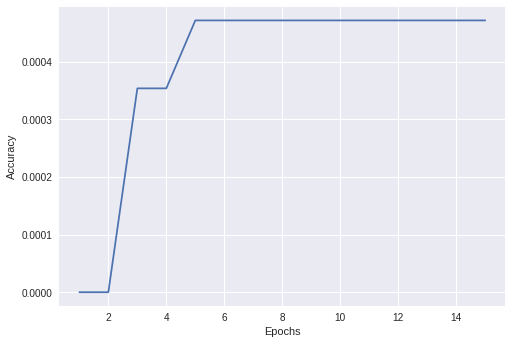

In [0]:
score = model.evaluate(x_test, y_testEnc, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
plt.plot(range(1, epochs+1), history.acc)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

In [0]:
from keras.layers import Input, Dense, Embedding, Conv2D, MaxPool2D
from keras.layers import Reshape, Flatten, Dropout, Concatenate
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras.models import Model
from sklearn.model_selection import train_test_split

#New CNN based on https://github.com/bhaveshoswal/CNN-text-classification-keras/blob/master/model.py
#x_train -> (15981, 30, 300)
#x_test  -> (3991, 30, 300)
#y_train -> (15981,)
#y_test  -> (3991,)


# load the data set, which already splits into train and test sets for us
x_train, y_train = np.array(MatrixList),np.array(Codes2)
x_test, y_test = np.array(testMatrixList),np.array(testCodes2)

sequence_length = x_train.shape[1] # 56
vocabulary_size = len(G) # 
print(x_train.shape)
print(sequence_length)
embedding_dim = 300#x_train.shape[2]
filter_sizes = [3,4,5]
num_filters = 512
drop = 0.5

epochs = 10
batch_size = 32

# this returns a tensor
print("Creating Model...")
inputs = Input(shape=(sequence_length,), dtype='int32')
print(inputs)
size_x, size_y = x_train.shape[1:]
print("size_x:",size_x,"size_y:",size_y)
vocabulary_size =  x_train.shape[0]# 18372

embedding = Embedding(input_dim=vocabulary_size, output_dim=embedding_dim, input_length=sequence_length)(inputs)
reshape = Reshape((sequence_length,embedding_dim,1))(embedding)

NameError: ignored

In [0]:
conv_0 = Conv2D(num_filters, kernel_size=(filter_sizes[0], embedding_dim), padding='valid', kernel_initializer='normal', activation='relu')
conv_1 = Conv2D(num_filters, kernel_size=(filter_sizes[1], embedding_dim), padding='valid', kernel_initializer='normal', activation='relu')
conv_2 = Conv2D(num_filters, kernel_size=(filter_sizes[2], embedding_dim), padding='valid', kernel_initializer='normal', activation='relu')(reshape)

maxpool_0 = MaxPool2D(pool_size=(sequence_length - filter_sizes[0] + 1, 1), strides=(1,1), padding='valid')(conv_0)
maxpool_1 = MaxPool2D(pool_size=(sequence_length - filter_sizes[1] + 1, 1), strides=(1,1), padding='valid')(conv_1)
maxpool_2 = MaxPool2D(pool_size=(sequence_length - filter_sizes[2] + 1, 1), strides=(1,1), padding='valid')(conv_2)

concatenated_tensor = Concatenate(axis=1)([maxpool_0, maxpool_1, maxpool_2])
flatten = Flatten()(concatenated_tensor)
dropout = Dropout(drop)(flatten)
output = Dense(units=2, activation='softmax')(dropout)

# this creates a model that includes
model = Model(inputs=inputs, outputs=output)

checkpoint = ModelCheckpoint('weights.{epoch:03d}-{val_acc:.4f}.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='auto')
adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
print("Traning Model...")
model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, callbacks=[checkpoint], validation_data=(X_test, y_test))  # starts training
